# Q1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import qrpm_funcs as qf
#Get regional stock market index data from Ken French's website.
#Convert daily to Wednesday-Wednesday weekly.

ff_head='http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/'
ff_foot="_3_Factors_Daily_CSV.zip"
ff_names=["Europe","North_America","Japan"]

for name_index in range(len(ff_names)):
    print("Inputting ",ff_names[name_index])
    ffurl=ff_head+ff_names[name_index]+ff_foot
    #Skip the header rows
    df_region = pd.read_csv(ffurl, skiprows=6)
    #Standardize name of Date column and market return column
    col0=df_region.columns[0]
    df_region.rename(columns={col0:'Date'},inplace=True)
    df_region.rename(columns={"Mkt-RF":ff_names[name_index]},inplace=True)
    #Merge into aggregate
    if name_index == 0:
        df_returns=df_region[df_region.columns[0:2]]
    else:
        df_returns = df_returns.merge(df_region[df_region.columns[0:2]], 
                            left_on='Date', right_on='Date')

#Convert to log-returns
df_logs_day=np.log(1+df_returns[df_returns.columns[1:]]/100)

#Convert dates to datetime format
df_logs_day.insert(0,"Date",df_returns["Date"],True)
df_logs_day["Date"] = pd.to_datetime(df_logs_day["Date"], format='%Y%m%d')
        
#Convert log-returns to weekly (Wednesday-Wednesday)
#to avoid asynchronous trading effects
df_logs_day = df_logs_day.set_index("Date")
df_logs=df_logs_day.resample('W-Wed').sum()
#(Will include some holidays like July 4 and December 25, so a little off)

#Force agreement with book
lastyear=2021
df_logs.drop(df_logs.index[df_logs.index.year>lastyear],axis=0,inplace=True)                 

periodicity=52   #For use in later code segments

nobs=len(df_logs)
print(nobs," weekly observations starting",df_logs.index[0].strftime("%Y-%m-%d"), \
      "ending",df_logs.index[-1].strftime("%Y-%m-%d"))

#Code Segment 10.13
import scipy.stats as spst
from scipy.optimize import minimize_scalar

#CHEAT! - get overall mean and standard deviation vectors
#In practice, would need to do everything out of sample - 
#start with a learning sample, e.g.
overallmean=np.mean(df_logs,axis=0)
overallstd=np.std(df_logs)
tickerlist=df_logs.columns

#Get GARCH params for each ticker
initparams=[.12,.85,.6]
gparams=[qf.Garch11Fit(initparams,df_logs[ticker]) for ticker in tickerlist]

minimal=10**(-20)
stgs=[] #Save the running garch sigmas
for it,ticker in enumerate(tickerlist):
    a,b,c=gparams[it]
    #Create time series of sigmas
    t=len(df_logs[ticker])
    stdgarch=np.zeros(t)
    stdgarch[0]=overallstd[ticker]
    #Compute GARCH(1,1) stddev's from data given parameters
    for i in range(1,t):
        #Note offset - i-1 observation of data
        #is used for i estimate of std deviation
        previous=stdgarch[i-1]**2
        var=c+b*previous+\
            a*(df_logs[ticker][i-1]-overallmean[ticker])**2
        stdgarch[i]=np.sqrt(var)
    #Save for later de-GARCHing
    stgs.append(stdgarch)

#Demeaned, DeGARCHed series go in dfeps
dfeps=df_logs.sort_values(by="Date").copy()
for it,ticker in enumerate(tickerlist):
    dfeps[ticker]-=overallmean[ticker]
    for i in range(len(dfeps)):
        dfeps[ticker].iloc[i]/=stgs[it][i]

Inputting  Europe
Inputting  North_America
Inputting  Japan
1644  weekly observations starting 1990-07-04 ending 2021-12-29


In [2]:
InData=np.array(dfeps[tickerlist])

In [3]:
def AsymmetricCorrObj(params):
    #Extract parameters
    alpha,beta,gamma=params
    #Enforce bounds
    if alpha<0 or beta<0 or gamma<0:
        return(10**20)
    elif (alpha+beta+gamma)>.999:
        return(10**20)
    obj10p34=0
    #Initial omega is obtained through correlation targeting
    Rlong=np.corrcoef(InData.T)
    previousq=np.identity(len(InData[0]))
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix
        #and compute contribution to objective
        #function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) \
                         for s in range(len(previousq))])
        previousr=np.matmul(stdmtrx,np.matmul(previousq,stdmtrx))
        #objective function
        obj10p34+=np.log(np.linalg.det(previousr))
        shockvec=np.array(InData[i])
        vec1=np.matmul(shockvec,np.linalg.inv(previousr))
        #This makes obj10p34 into a 1,1 matrix
        obj10p34+=np.matmul(vec1,shockvec)
              
        #Update q matrix
        neta = np.mat([[shockvec[j]*shockvec[i] if (shockvec[i]<0 and shockvec[j]<0) else 0 for i in range(len(previousq))] 
                for j in range(len(previousq))])
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq+gamma*neta
    return(obj10p34[0,0])

import scipy.optimize as scpo
#alpha beta gamma positive
corr_bounds = scpo.Bounds([0,0,0],[np.inf,np.inf,np.inf])
#Sum of alpha and beta and gamma is less than 1
corr_linear_constraint = scpo.LinearConstraint([[1, 1, 1]],[0],[.999])

initparams=[.03,.8,.05]

results = scpo.minimize(AsymmetricCorrObj, \
        initparams, \
        bounds=corr_bounds, \
        constraints=corr_linear_constraint)

alpha,beta,gamma=results.x
print('Optimal alpha, beta, gamma:',alpha,beta,gamma)
print('Optimal objective function:',results.fun)
halflife=-np.log(2)/np.log(beta)
print('Half-life (years):',halflife/periodicity)

Optimal alpha, beta, gamma: 0.014542392493483644 0.9765014143293852 3.2043718804638228e-09
Optimal objective function: 3279.6731949240175
Half-life (years): 0.5605664013862288


In [4]:
#Compute correlations
nobs=len(InData)
nsecs=len(InData[0])
previousq=np.identity(nsecs)
Rlong=np.corrcoef(InData.T)
rmatrices=[]
for i in range(nobs):
    stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(nsecs)])
    rmatrices.append(np.matmul(stdmtrx,np.matmul(previousq,stdmtrx)))
    #Update q matrix
    shockvec = np.array(InData[i])
    neta = np.mat([[shockvec[i]*shockvec[j] if (shockvec[i]<0 and shockvec[j]<0) else 0 for i in range(len(previousq))] 
                for j in range(len(previousq))])
    shockvec=np.mat(shockvec)
    shockmat=np.matmul(shockvec.T,shockvec)
    previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq+gamma*neta

#Plot correlations
iccol=['r','g','b']
xtitle='Asymmetric Correlations α=%1.5f' % alpha
xtitle+=', β=%1.5f' % beta
xtitle+=', γ=%1.5f' % gamma
xtitle+=',\n'+min(df_logs.index.strftime("%Y-%m-%d"))+':'+ \
             max(df_logs.index.strftime("%Y-%m-%d"))
dates=df_logs.index
stride=5*periodicity


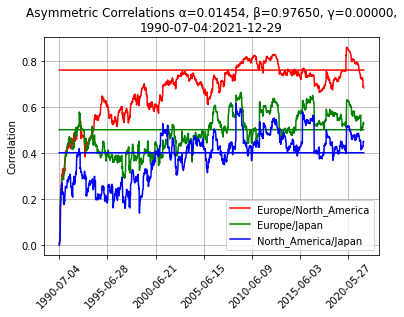

In [5]:
def plot_corrs(dates,corrs,corr_matrix,sccol,stride,title_str):
    #dates and corrs have same length
    #dates in datetime format
    #corrs is a list of correlation matrices
    #corr_matrix has the target correlations
    #names of securities are the column names of corr_matrix
    #sccol is colors for lines
    #stride is how many dates to skip between ticks on x-axis
    #title_str is title string

    nobs=len(corrs)
    nsecs=len(corrs[0])

    #plot correlations in corrs, nsec per time period
    ncorrs=nsecs*(nsecs-1)/2
    z=0
    #Go through each pair
    for j in range(nsecs-1):
        for k in range(j+1,nsecs):
            #form time series of sample correlations
            #for this pair of securities
            cs=[corrs[i][j,k] for i in range(nobs)]
            plt.plot(range(nobs),cs, \
                     label=corr_matrix.columns[j]+'/'+ \
                     corr_matrix.columns[k], \
                     color=sccol[z])
            #Show target correlation in same color
            line=[corr_matrix.iloc[j,k]]*(nobs)
            plt.plot(range(nobs),line,color=sccol[z])
            z+=1

    plt.legend()
    tix=[x.strftime("%Y-%m-%d") for x in dates[0:nobs+1:stride]]
    plt.xticks(range(0,nobs+1,stride),tix,rotation=45)
    plt.ylabel("Correlation")
    plt.title(title_str)
    plt.grid()
    plt.show();

corr_matrix=df_logs[df_logs.columns].corr()
plot_corrs(dates,rmatrices,corr_matrix,iccol,stride,xtitle)

#### Optimal objective function under mean-reversion is 3279.8466 and that under asymmetric model is 3279.6732. There is NOT a noticeable improvement in the log-maximum-likelihood from using the asymmetric model compared to the meanreverting model.

# Q2

In [6]:
import numpy as np
import pandas as pd
import qrpm_funcs as qf

#Get 4 currencies until the end of previous year.
firstday='1999-01-04'
lastday=qf.LastYearEnd()
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS','DEXUSEU']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
            startdate=firstday,enddate=lastday)
multipliers=[-1,1,-1,1]

lgdates,difflgs=qf.levels_to_log_returns(cdates,ratematrix,multipliers)

#Put data in df_logs so it looks like Chapter 10 data
from datetime import datetime

df_logs = pd.DataFrame(difflgs, \
            index=[datetime.strptime(lg,"%Y-%m-%d") for lg in lgdates], \
            columns=seriesnames)
periodicity=252   #For use in later code segments
nobs=len(df_logs)
print(nobs," daily observations starting",df_logs.index[0], \
      "ending",df_logs.index[-1])

#Code Segment 10.13 (truncated)
import scipy.stats as spst
from scipy.optimize import minimize_scalar

#CHEAT! - get overall mean and standard deviation vectors
#In practice, would need to do everything out of sample - 
#start with a learning sample, e.g.
overallmean=np.mean(df_logs,axis=0)
overallstd=np.std(df_logs)
tickerlist=df_logs.columns

#Get GARCH params for each ticker
initparams=[.12,.85,.6]
gparams=[qf.Garch11Fit(initparams,df_logs[ticker]) for ticker in tickerlist]

minimal=10**(-20)
stgs=[] #Save the running garch sigmas
for it,ticker in enumerate(tickerlist):
    a,b,c=gparams[it]
    
    #Create time series of sigmas
    t=len(df_logs[ticker])
    stdgarch=np.zeros(t)
    stdgarch[0]=overallstd[ticker]
    #Compute GARCH(1,1) stddev's from data given parameters
    for i in range(1,t):
        #Note offset - i-1 observation of data
        #is used for i estimate of std deviation
        previous=stdgarch[i-1]**2
        var=c+b*previous+\
            a*(df_logs[ticker][i-1]-overallmean[ticker])**2
        stdgarch[i]=np.sqrt(var)

    #Save for later de-GARCHing
    stgs.append(stdgarch)
    stdgarch=100*np.sqrt(periodicity)*stgs[it]  #Annualize

#Display before and after deGARCHing statistics

#Demeaned, DeGARCHed series go in dfeps
dfeps=df_logs.sort_index().copy()
for it,ticker in enumerate(tickerlist):
    dfeps[ticker]-=overallmean[ticker]
    for i in range(len(dfeps)):
        dfeps[ticker].iloc[i]/=stgs[it][i]
    print(ticker)
    print('    DeGARCHed Mean:',np.mean(dfeps[ticker]))
    
    print('    Raw annualized Std Dev:',np.sqrt(periodicity)*overallstd[ticker])
    print('    DeGARCHed Std Dev:',np.std(dfeps[ticker]))
    
    print('    Raw excess kurtosis:',spst.kurtosis(df_logs[ticker]))
    print('    DeGARCHed Excess Kurtosis:',spst.kurtosis(dfeps[ticker]))

5769  daily observations starting 1999-01-05 00:00:00 ending 2021-12-30 00:00:00
DEXSZUS
    DeGARCHed Mean: 0.004817348710103456
    Raw annualized Std Dev: 0.10449950596877113
    DeGARCHed Std Dev: 1.0004191685370174
    Raw excess kurtosis: 34.42574543221702
    DeGARCHed Excess Kurtosis: 51.10560927358378
DEXUSUK
    DeGARCHed Mean: 0.0038927008260490315
    Raw annualized Std Dev: 0.09322540907165834
    DeGARCHed Std Dev: 0.9993435891721617
    Raw excess kurtosis: 10.701988782825639
    DeGARCHed Excess Kurtosis: 2.0090313950129817
DEXJPUS
    DeGARCHed Mean: -0.001725315504052021
    Raw annualized Std Dev: 0.09883529580329846
    DeGARCHed Std Dev: 1.0015062220352673
    Raw excess kurtosis: 4.27859039795758
    DeGARCHed Excess Kurtosis: 2.802613561501861
DEXUSEU
    DeGARCHed Mean: 0.0006416783378314604
    Raw annualized Std Dev: 0.09387950032107568
    DeGARCHed Std Dev: 0.9999300599801308
    Raw excess kurtosis: 2.530457903400185
    DeGARCHed Excess Kurtosis: 1.1936780

In [7]:
def IntegratedCorrObj(s):
    #Compute time series of quasi-correlation
    #matrices from InData using integrated parameter
    #xlam=exp(s)/(1+exp(s)); note this format removes
    #the need to enforce bounds of xlam being between
    #0 and 1. This is applied to formula 10.29.
    #Standardize Q's and apply formula 10.34.
    #Returns scalar 10.34
    xlam=np.exp(s)
    xlam/=1+xlam
    obj10p34=0.
    previousq=np.identity(len(InData[0]))
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix
        #and compute contribution to objective
        #function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
        previousr=stdmtrx @ (previousq @ stdmtrx)
        #objective function
        obj10p34 += np.log(np.linalg.det(previousr))
        shockvec = np.array(InData[i])
        vec1=shockvec @ np.linalg.inv(previousr)
        #This makes obj10p34 into a 1,1 matrix
        obj10p34+=vec1 @ shockvec
              
        #Update q matrix
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=xlam*shockmat+(1-xlam)*previousq
    return(obj10p34[0,0])

#Code Segment 10.19
#MacGyver method - pairwise integrated
minimal=10**(-20)
xlams=[]
half_life = []
for it in range(len(tickerlist)-1):
    tick1=tickerlist[it]
    for jt in range(it+1,len(tickerlist)):
        tick2=tickerlist[jt]
        InData=np.array(dfeps[[tick1,tick2]])
        result=minimize_scalar(IntegratedCorrObj)
        xlamopt=np.exp(result.x)/(1+np.exp(result.x))
        print(tick1,tick2)
        print('    Optimal lambda:',xlamopt)
        print('    Optimal objective function:', \
              result.fun)
        if np.absolute(xlamopt)<minimal or xlamopt>=1:
            halflife=0
        else:
            halflife=-np.log(2)/np.log(1-xlamopt)
        print('    Half-life (years):',halflife/periodicity)
        xlams.append(xlamopt)
        half_life.append(halflife/periodicity)

print('\nMedian MacGyver lambda:',np.median(xlams))
print('\nMedian MacGyver half-life:',np.median(half_life))

DEXSZUS DEXUSUK
    Optimal lambda: 0.014636607198197177
    Optimal objective function: 9370.240122467829
    Half-life (years): 0.18654630380676632
DEXSZUS DEXJPUS
    Optimal lambda: 0.035028344800794864
    Optimal objective function: 10267.215813700648
    Half-life (years): 0.07714105763113281
DEXSZUS DEXUSEU
    Optimal lambda: 0.001974411679022396
    Optimal objective function: 7182.585350319985
    Half-life (years): 1.3917400266452584
DEXUSUK DEXJPUS
    Optimal lambda: 0.021548318754306284
    Optimal objective function: 11063.645892214125
    Half-life (years): 0.12626698424874777
DEXUSUK DEXUSEU
    Optimal lambda: 0.019644707095760484
    Optimal objective function: 8412.835434897446
    Half-life (years): 0.13863670708928705
DEXJPUS DEXUSEU
    Optimal lambda: 0.029863784231039928
    Optimal objective function: 10562.41047019096
    Half-life (years): 0.09072209564827377

Median MacGyver lambda: 0.020596512925033384

Median MacGyver half-life: 0.1324518456690174


#### We can see that median half-life from the MacGyver Method is 0.1325, while that from integrated model with quasi-correlation matrix is 1.185.